In [1]:
import numpy as np
import setigen as stg
from blimpy import Waterfall
import matplotlib.pyplot as plt
import random
import os
from astropy import units as u
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"]="0"
num_classes = 100
num_samples_per_class = 1000


In [2]:
import os

directory = os.fsencode( "../../../../../datax/scratch/pma/reverse_search/test/")
count = 0
data = []
for folder in os.listdir(directory):
    print(folder)
    for subfolder in os.listdir(directory+folder):
        back = os.fsencode( "/")
        if '.' not in str(subfolder):
            for file in os.listdir(directory+folder+back+subfolder):
                file_directory = str(os.path.join(directory+folder+back+subfolder, file)).replace('b', '').replace("'","")
                if 'filtered.npy' in file_directory:
                    data.append(np.load(str(file_directory)))
                    count += 1
data = np.vstack(data)
print(data.shape)

b'HIP104887-1850'
b'HIP87579-1008'
b'clustering_tests'
(347064, 16, 256)


In [3]:
def painting(data):
    all_data = []
    labels = []
    for c in tqdm(range(num_classes)):
        drift = 2*random.random()*(-1)**random.randint(0,2)
        snr = random.randint(100, 150)
        width = random.randint(20, 50)
        for s in range(num_samples_per_class):
            index = random.randint(0, data.shape[0]-1)
            window = data[index, :,:]
            
            start = random.randint(50, 180)
            
            frame = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                                        dt=18.253611008*u.s,
                                        fch1=1289*u.MHz,
                                        ascending=True,
                                        data=window)
            frame.add_signal(stg.constant_path(
                                        f_start=frame.get_frequency(index=start),
                                       drift_rate=drift*u.Hz/u.s),
                                      stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
                                      stg.gaussian_f_profile(width=width*u.Hz),
                                      stg.constant_bp_profile(level=1))
            all_data.append(frame.data)
            labels.append(c)
    all_data = np.array(all_data)
    labels = np.vstack(labels)
    return all_data, labels

In [4]:
injected, labels = painting(data)

100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


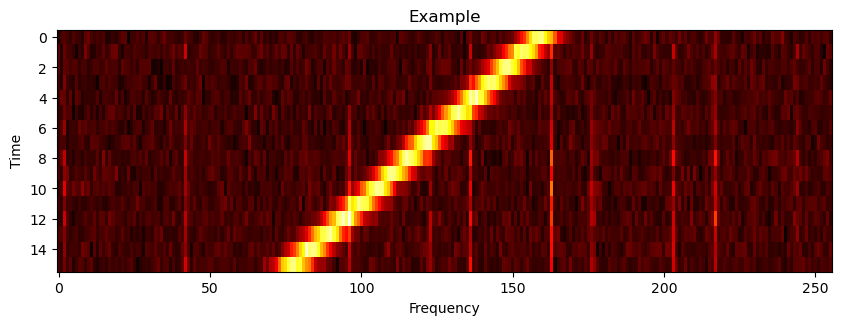

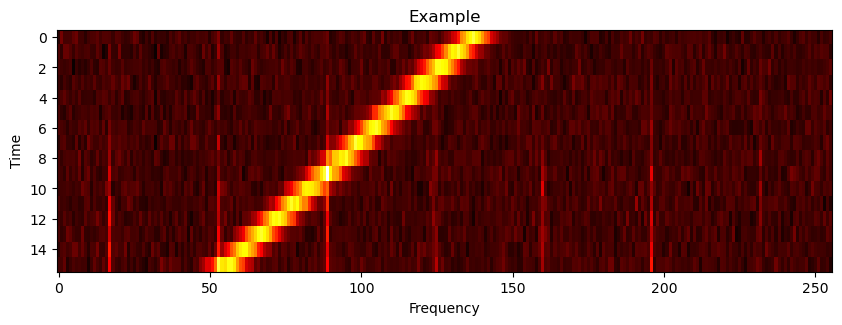

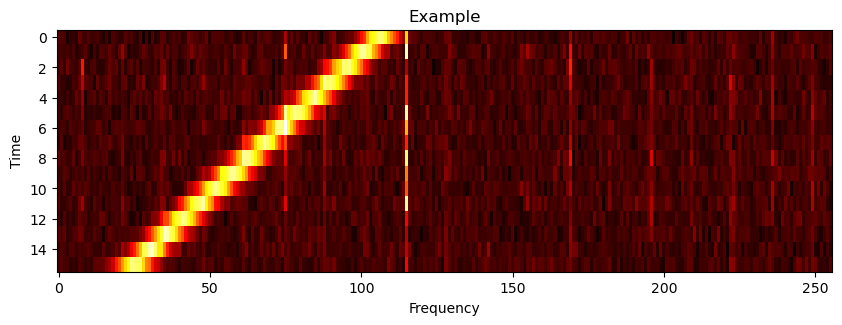

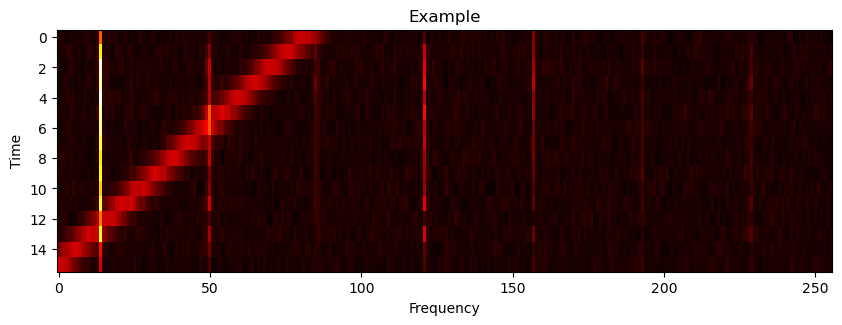

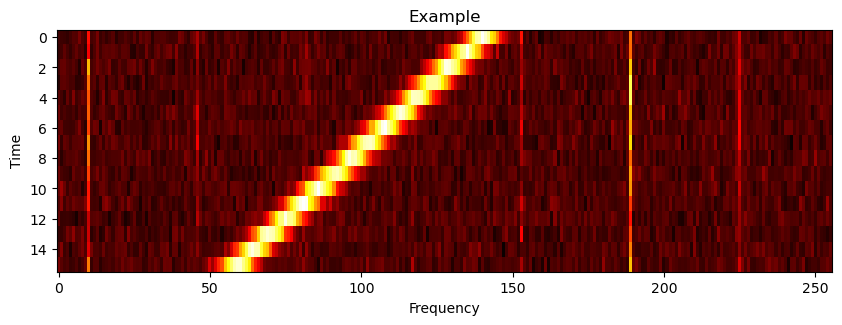

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
class_id = random.randint(0,100)
for i in range(class_id * num_samples_per_class, class_id * num_samples_per_class+5):
    plt.rcParams.update({'font.size': 10})
    plt.figure(figsize=(10,5))
    plt.title("Example")
    plt.xlabel("Frequency")
    plt.ylabel("Time")
    plt.imshow(injected[i, :, :], cmap='hot', aspect=5)

In [6]:
import cv2
import numpy as np

def transform(data):
    final = []
    for i in tqdm(range(data.shape[0])):
        img = np.repeat(data[i,:, :], 3, axis=2)
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        final.append(res)
    return np.array(final)


In [7]:
from tqdm import tqdm
import gc

def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    for i in tqdm(range(data.shape[0])):
        data[i,:,:] = normalize(data[i,:,:, :])
    return data

print(data.shape)
input_data = transform(np.expand_dims(data[:100000], axis = -1))
del data
gc.collect()
input_data = normalize_data(input_data[:100000, :,:])
print(input_data[0,:,:].max(), input_data[0,:,:].min())



(347064, 16, 256)


100%|██████████████████████████████████| 100000/100000 [04:11<00:00, 398.08it/s]

1.0 0.0


In [8]:
input_data.shape

(100000, 224, 224, 3)

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model
model = ResNet50( include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000
                )
truncated_model = Model(inputs = model.layers[0].input, outputs = model.layers[-1].output)
truncated_model.summary()
truncated_model.compile(optimizer='rmsprop')

2023-05-27 09:36:14.696139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 09:36:20.486483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 09:36:20.998778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14233 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [10]:
print(input_data.shape)

(100000, 224, 224, 3)


In [11]:
from sklearn.metrics import silhouette_score
import tensorflow as tf
features = []
for i in tqdm(range(1,100)):
    tensor = tf.convert_to_tensor(input_data[1_000*(i-1):1_000*i, :, :, :], dtype=tf.float32)
    features.append( model(tensor))
del input_data
gc.collect()
features = np.vstack(features)

  0%|                                                    | 0/99 [00:00<?, ?it/s]2023-05-27 09:36:24.720603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-27 09:36:27.222551: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-27 09:36:27.222622: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-27 09:36:27.350852: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.79GiB with freed_by_count=0. The caller indicates that thi

In [16]:
features.shape

(99000, 1000)

In [17]:
score = silhouette_score(X = features[:99_000,:], labels = labels[:99_000,0])
print(score)

-0.22712646


# Disentanglement

In [14]:
def idealized(num=10_000):
    drift = 0
    snr = 20
    width = 10
    start = 256//2
    data = []
    labels = []
    for tag in range(4):
        label_vec = np.zeros(4)
        label_vec[tag] = 1
        for i in tqdm(range(num)):
            if tag == 0:
                drift = (-1)**(random.randint(0,2)) * 2 *random.random()
            elif tag == 1:
                snr = 50*random.random() +20
            elif tag == 2:
                width = 50*random.random() +20
            elif tag == 3:
                start = random.randint(50, 180)

            frame = stg.Frame(fchans=256*u.pixel,
                              tchans=16*u.pixel,
                              df=2.7939677238464355*u.Hz,
                              dt=18.253611008*u.s,
                              fch1=6095.214842353016*u.MHz)
            noise = frame.add_noise(x_mean=10, noise_type='chi2')
            frame.add_signal(stg.constant_path(
                                        f_start=frame.get_frequency(index=start),
                                       drift_rate=drift*u.Hz/u.s),
                                      stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
                                      stg.gaussian_f_profile(width=width*u.Hz),
                                      stg.constant_bp_profile(level=1))
            data.append(frame.data)
            labels.append(label_vec)
    data = np.array(data)
    labels = np.vstack(labels)
    return data, labels

In [15]:
idealized_signals.shape

NameError: name 'idealized_signals' is not defined

In [ ]:
idealized_signals, labels = idealized(num = 10_000)
idealized_signals = transform(np.expand_dims(idealized_signals, axis = -1))


In [ ]:
idealized_signals.shape

In [ ]:
# idealized_signals = np.expand_dims(normalize_data(idealized_signals), axis = -1)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(idealized_signals[0, :, :, 0], cmap='hot', aspect=1)

In [ ]:
idealized_signals.shape

In [ ]:
X = []
for i in range(1,50):
    X.append( model.predict(idealized_signals[1_000*(i-1):1_000*i, :, :, :], batch_size = 32, verbose=1))
X = np.vstack(X)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)
del X
gc.collect()

# Build Linear Classifier

In [ ]:
linear = keras.Sequential(name="my_sequential")
linear.add(layers.Dense(8, activation="linear", name="layer1"))
linear.add(layers.Dense(4, activation="softmax", name="layer2"))


linear.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
linear.fit(X_train, y_train, epochs=150, batch_size=64, validation_split = 0.1, shuffle=True)


In [ ]:
linear.evaluate(X_test, y_test)